In [1]:
import os
import numpy as np
import time

import pandas as pd
from PIL import Image
from skimage.morphology import remove_small_objects, remove_small_holes

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import cv2

In [2]:
from models.linknet import UNetResnet

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

net = UNetResnet().to(device)

net.load_state_dict(torch.load('weights/linknet34_best'))
net.eval()
print("ready")

ready


In [3]:
cap = cv2.VideoCapture(0)
assert cap.isOpened(), 'Cannot capture source'

In [6]:
threshold=0.25

frames = 0
start = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    
    if ret:
        img = transforms.ToTensor()(frame).unsqueeze(0).to(device)
        
    with torch.no_grad():
        output = net.forward(img)

    output = output[0].cpu().numpy()
    mask = remove_small_holes(remove_small_objects(output > threshold))
    
    for i in range(3):
        frame[:,:,i] = frame[:,:,i]*mask[0,:,:]

    cv2.imshow("frame", frame)
    key = cv2.waitKey(1)
    if key & 0xFF == ord('q'):
        break
    frames+=1
    #print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))
cv2.destroyAllWindows()

In [81]:
from torch.utils.data import DataLoader
from torchvision import transforms
from FaceDataset import FaceDataset

tensor_transforms = transforms.Compose([
    transforms.ToTensor()
    ])

path_images = list(filter(lambda x: x.endswith('.jpg'), os.listdir('data/test/')))

test_data_loader = DataLoader(
    FaceDataset('data/test', path_images, tensor_transforms=tensor_transforms), batch_size=1)

2177 images


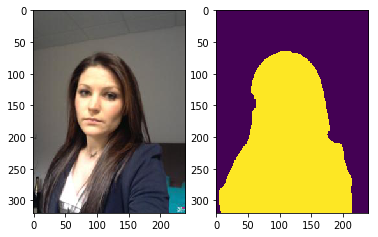

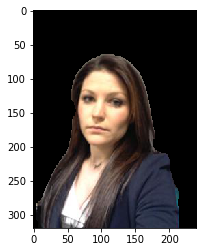

In [82]:
import matplotlib.pyplot as plt
for batch in test_data_loader:
    break

orig = batch['img'].cpu().numpy()

batch['img'] = batch['img'].to(device)
with torch.no_grad():
    output = net.forward(batch['img'])

img = output[0].detach().cpu().numpy()
post_img = remove_small_holes(remove_small_objects(img > 0.25))

fig=plt.figure()
fig.add_subplot(1,2, 1)
plt.imshow(orig[0].transpose((1,2,0)))
fig.add_subplot(1,2, 2)
plt.imshow(post_img[0])
plt.show()

plt.imshow(orig[0].transpose((1,2,0))[:,:,:] * post_img[0,:,:,np.newaxis])